In [ ]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from google.colab import drive

# ====== Mount Drive ======
drive.mount('/content/drive')

# ====== Define Save Paths ======
base_dir = "/content/drive/MyDrive/Colab Notebooks/vae_outputs"
checkpoint_dir = os.path.join(base_dir, "Model checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# ====== Settings ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 10  # <<<<<< You can change this value
epochs = 50
batch_size = 128

# ====== Load MNIST Dataset ======
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ====== Define VAE Model ======
class VAE(nn.Module):
    def __init__(self, latent_dim=2, beta=1.0):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.fc1 = nn.Linear(28*28, 256)
        self.fc21 = nn.Linear(256, latent_dim)  # mu
        self.fc22 = nn.Linear(256, latent_dim)  # logvar
        self.fc3 = nn.Linear(latent_dim, 256)
        self.fc4 = nn.Linear(256, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x.view(-1, 28*28)))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# ====== Loss Function ======
def loss_function(recon_x, x, mu, logvar, beta):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

# ====== Train Function ======
def train_vae(model, optimizer, model_name='vae'):
    model.train()
    model_path = os.path.join(checkpoint_dir, f'{model_name}_latest.pt')

    for epoch in range(1, epochs + 1):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar, model.beta)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        # Save model (overwrite previous)
        torch.save(model.state_dict(), model_path)

        print(f'[{model_name}] Epoch {epoch:3d} / {epochs} | Loss: {train_loss / len(train_loader.dataset):.4f}')

# ====== Plot Latent Space ======
def plot_latent_space(model, model_name='vae'):
    if latent_dim != 2:
        print(f"Skipping latent space plot for {model_name}: latent_dim={latent_dim} (not 2)")
        return

    model.eval()
    zs, labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            mu, _ = model.encode(x.view(-1, 28*28))
            zs.append(mu.cpu())
            labels.append(y)
    zs = torch.cat(zs).numpy()
    labels = torch.cat(labels).numpy()

    plt.figure(figsize=(6, 6))
    plt.scatter(zs[:, 0], zs[:, 1], c=labels, cmap='tab10', s=2, alpha=0.6)
    plt.colorbar()
    plt.title(f'Latent Space ({model_name})')
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.grid(True)
    plot_path = os.path.join(base_dir, f'{model_name}_latent_space.png')
    plt.savefig(plot_path, dpi=300)
    plt.close()

# ====== Initialize and Train Models ======
for beta in [1.0, 4.0]:
    model_name = f'vae_b{beta}_z{latent_dim}'
    vae = VAE(latent_dim=latent_dim, beta=beta).to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

    train_vae(vae, optimizer, model_name=model_name)

    # Final latent space plot (only if 2D)
    plot_latent_space(vae, model_name=model_name)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[vae_b1.0_z10] Epoch   1 / 50 | Loss: 172.5501
[vae_b1.0_z10] Epoch   2 / 50 | Loss: 128.8867
[vae_b1.0_z10] Epoch   3 / 50 | Loss: 122.8862
[vae_b1.0_z10] Epoch   4 / 50 | Loss: 119.8002
[vae_b1.0_z10] Epoch   5 / 50 | Loss: 117.8782
[vae_b1.0_z10] Epoch   6 / 50 | Loss: 116.5163
[vae_b1.0_z10] Epoch   7 / 50 | Loss: 115.5311
[vae_b1.0_z10] Epoch   8 / 50 | Loss: 114.6309
[vae_b1.0_z10] Epoch   9 / 50 | Loss: 113.9918
[vae_b1.0_z10] Epoch  10 / 50 | Loss: 113.4044
[vae_b1.0_z10] Epoch  11 / 50 | Loss: 112.8802
[vae_b1.0_z10] Epoch  12 / 50 | Loss: 112.4072
[vae_b1.0_z10] Epoch  13 / 50 | Loss: 112.0385
[vae_b1.0_z10] Epoch  14 / 50 | Loss: 111.6701
[vae_b1.0_z10] Epoch  15 / 50 | Loss: 111.3630
[vae_b1.0_z10] Epoch  16 / 50 | Loss: 111.0523
[vae_b1.0_z10] Epoch  17 / 50 | Loss: 110.7546
[vae_b1.0_z10] Epoch  18 / 50 | Loss: 110.5514
[vae_b1.0_z10] Epoch  19 

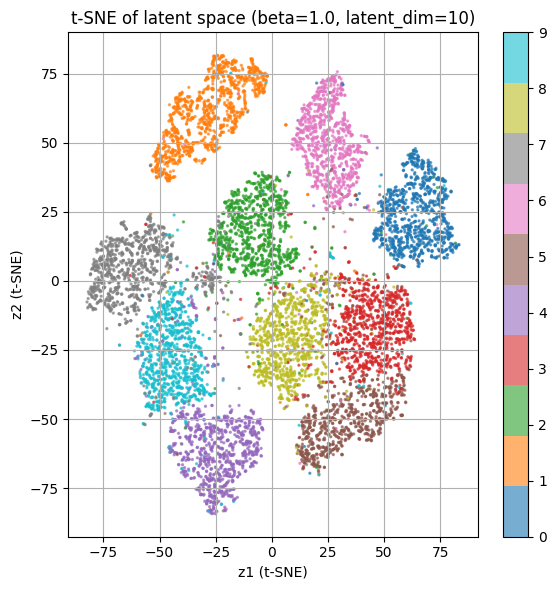

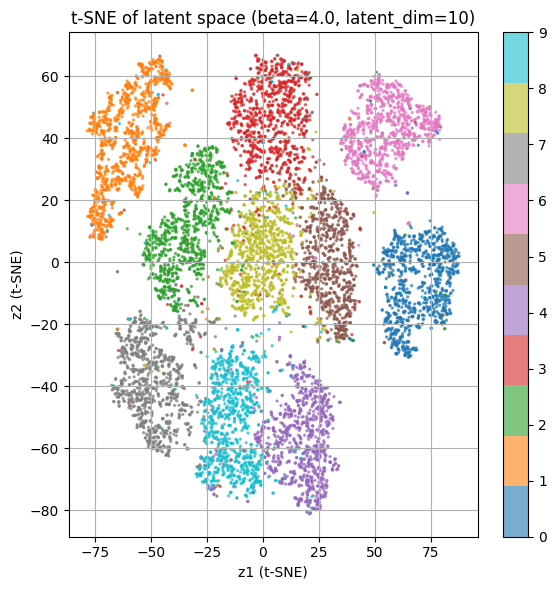

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os

# ===== Set Parameters =====
latent_dim = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_root = "/content/drive/MyDrive/Colab Notebooks/vae_outputs/Model checkpoints"

# ===== Load MNIST Test Data =====
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# ===== Define the VAE Model Class =====
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(28*28, 256)
        self.fc21 = nn.Linear(256, latent_dim)
        self.fc22 = nn.Linear(256, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 256)
        self.fc4 = nn.Linear(256, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x.view(-1, 28*28)))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# ===== Load Model and Plot t-SNE =====
def load_and_plot_tsne(model_name, beta):
    # Load model
    model = VAE(latent_dim=latent_dim).to(device)
    checkpoint_path = os.path.join(data_root, model_name)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    zs, labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            mu, _ = model.encode(x)
            zs.append(mu.cpu())
            labels.append(y)

    zs = torch.cat(zs).numpy()
    labels = torch.cat(labels).numpy()

    # Dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=30, init='random', random_state=42)
    z_2d = tsne.fit_transform(zs)

    # Plot
    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='tab10', s=2, alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f"t-SNE of latent space (beta={beta}, latent_dim={latent_dim})")
    plt.xlabel("z1 (t-SNE)")
    plt.ylabel("z2 (t-SNE)")
    plt.grid(True)
    plt.tight_layout()
    save_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/vae_outputs", f"vae_b{beta}_z{latent_dim}_tsne.png")
    plt.savefig(save_path, dpi=300)
    plt.show()

# ===== Plot both models =====
load_and_plot_tsne("vae_b1.0_z10_latest.pt", beta=1.0)
load_and_plot_tsne("vae_b4.0_z10_latest.pt", beta=4.0)
